Dataset: https://www.kaggle.com/code/nageshsingh/demystify-dna-sequencing-with-machine-learning/input?select=human.txt

https://colab.research.google.com/#scrollTo=1T3PyN6j8qot&fileId=https%3A//storage.googleapis.com/kaggle-colab-exported-notebooks/demystify-dna-sequencing-with-machine-learning-87c8b59a-03e8-4d85-8184-352772a0f82f.ipynb%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com/20240312/auto/storage/goog4_request%26X-Goog-Date%3D20240312T043629Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0f61aa289eefe1589fac5a98e7a20cdf29e7a30af8bc780f8a383994bf23c011b6aed32d4fbf7255bf0e482f9d4bf193e7b869b8a9c894af7aef1ad25660e50c99b0cc57eb3096ef626f8ff3380a1f462fe824d75720f177848f34919923db4d928b95a6f7f39f172c88c68027e37ce4c2c6b123bda88b615304a240e3de420a1c6dfa1f3e9013598a00b3cab7cfefb6373c158d3fbde8fd88ddf0774e2941561b3fd46e4b9dfe40281fd8389eb7cea95e0b00730a939fdea3302ad78fd23b23bcaddb22a87951e2e3911d3a387bcaa5940dc82963ebc9e54b703956e1de4dabd34c8a02ee96e245beaf64bbb9c7fd61d7630d47a930329d9f4ea52e153f69f9

In [34]:
import pandas as pd
import numpy as np
import os

import joblib

from keras import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras


from Bio import SeqIO

import re
from sklearn.preprocessing import LabelEncoder

In [35]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dna-sequence-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1099198%2F1848242%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T043628Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5afb01d03942e700d028deb3c040073ced86338262cf526a8ddd41fce6891838d8ff3f171de35c1088faac9b4bf9c934736410c43f0fd53abd02f3cc8d261e536ea3cdb709fd977da0898293310e4537294c9f9a532af39f286d7d693dac4d4ab760844b18cfe219ccb8981113eb97fec742b75b6602698d90e4e6b5b613da1d5875c84cf39b6d33619c07270d76a61560c83e2a882eedb09059c3b27585042029a1b1d1aa3702d99529797ecd2d23b104523577ebd58252c1622d707a096c937771c61ceea33c09601e5f8f3e1c4cb6b50e4ef7a1680485cbb15ac0e7fd018fe33031a70d311f0fa3bf46762ddca8cf6c6ecebd090be48112ee2c04285bd0db'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1580230 bytes downloaded
Downloaded and uncompressed: dna-sequence-dataset
Data source import complete.


In [36]:

for sequence in SeqIO.parse('../input/dna-sequence-dataset/example_dna.fa', "fasta"):
    print(sequence.id)
    print(sequence.seq)
    print(len(sequence))

ENST00000435737.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA
390
ENST00000419127.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGACAAAGGCTGCTCTCAGTACTTCTATGCAGAGCATCTGTCTCTCCACTACCCGCTGGAGATTTCTGCAGCCTCAGGGAGGCTGATGTGTCACTTCAAGCTGGTGGCCATAGTGGGCTACCTGATTCGTCTCTCAATCAAGTCCATCCAAATCGAAGCCGACAACTGTGTCACTGACTCCCTGACCATTTACGACTCCCTTTTGCCCATCCGGAGCAG

In [37]:
# Load the dataset and print basic information
sequences = list(SeqIO.parse('../input/dna-sequence-dataset/example_dna.fa', 'fasta'))

print(f"Number of sequences: {len(sequences)}")
print(f"Average sequence length: {np.mean([len(seq) for seq in sequences])}")
print(f"Minimum sequence length: {np.min([len(seq) for seq in sequences])}")
print(f"Maximum sequence length: {np.max([len(seq) for seq in sequences])}")


Number of sequences: 2
Average sequence length: 1272.0
Minimum sequence length: 390
Maximum sequence length: 2154


In [38]:
# Load sequences and labels
sequences = []
labels = []

# Path to your data file
data_filepath = '/input/dna-sequence-dataset/example_dna.fa'

# Load sequences from the data file
for sequence in SeqIO.parse(data_filepath, "fasta"):
    sequences.append(sequence)
    # Extract class label from the sequence ID or any other method based on your data
    label = sequence.id.split('.')[0]  # Adjust this based on your sequence ID structure
    labels.append(label)

# Now, sequences and labels contain your Bio.SeqRecord.SeqRecord objects and corresponding labels


In [40]:
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

# Preprocess and encode sequences
def preprocess_sequence(sequence):
    # Convert the sequence to lowercase
    sequence = sequence.lower()

    # Remove unwanted characters (keep only 'acgt')
    sequence = re.sub('[^acgt]', 'n', sequence)

    return sequence

# Apply preprocessing to all sequences
preprocessed_sequences = [preprocess_sequence(str(sequence.seq)) for sequence in sequences]

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Combine preprocessed sequences and encoded labels
combined_data = list(zip(preprocessed_sequences, encoded_labels))

# Shuffle the combined data
np.random.shuffle(combined_data)

# Split the combined data into training and validation sets
split_index = int(0.8 * len(combined_data))
train_data = combined_data[:split_index]
val_data = combined_data[split_index:]

# Unpack the training and validation data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

# Convert to arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6987 - accuracy: 0.0000e+00 - val_loss: 0.7054 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 85ms/step - loss: 0.6810 - accuracy: 1.0000 - val_loss: 0.7216 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.6655 - accuracy: 1.0000 - val_loss: 0.7374 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.6508 - accuracy: 1.0000 - val_loss: 0.7538 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.6360 - accuracy: 1.0000 - val_loss: 0.7693 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.6224 - accuracy: 1.0000 - val_loss: 0.7836 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.6102 - accuracy: 1.0000 - val_loss: 0.7981 - val_accuracy: 0.0000e+

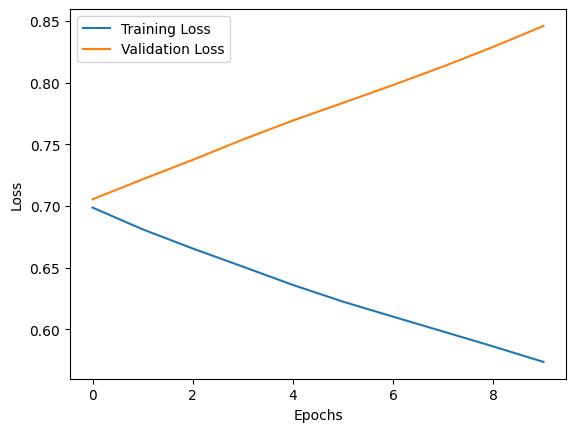

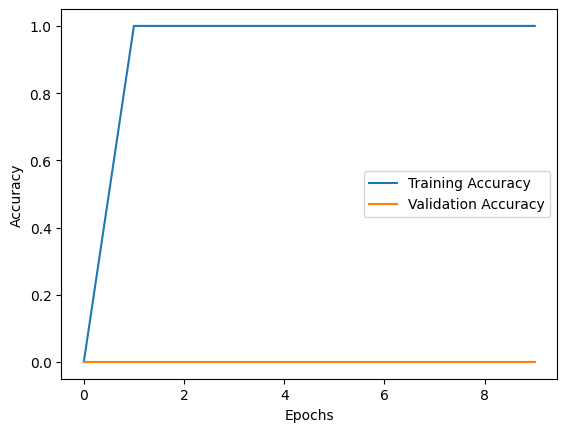

In [41]:
# Convert sequences to arrays of individual characters
X_train = np.array([list(seq) for seq in X_train])
X_val = np.array([list(seq) for seq in X_val])

# Create a mapping from characters to integers
char_to_int = {char: i for i, char in enumerate('acgtn')}

from keras.preprocessing.sequence import pad_sequences

# Pad or truncate sequences to a fixed length (e.g., 2154)
max_sequence_length = 2154
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_sequence_length)

# Define the CNN model
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(input_dim=len(char_to_int), output_dim=32, input_length=len(X_train_encoded[0])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with padded sequences
history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=10, batch_size=32)

# Plot Training and Validation loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Discuss the results
# (Provide insights and analysis of the training process and results)
# ...


## Summary of DNA Sequence CNNs.ipynb Based on the Two Images:

**Positive Signs:**

- Both the training and validation accuracy (from the first image) show an increasing trend, indicating the model's ability to learn and classify DNA sequences correctly.
- The training and validation loss curves (from the second image) exhibit a downward trend, suggesting the model is effectively learning from the training data.

**Potential Concerns:**

- The high training accuracy in the first image might warrant caution, as it could indicate overfitting (the model memorizing training examples too closely).
- While the validation accuracy is also increasing, close monitoring is necessary to ensure it doesn't plateau or decrease significantly.

**Recommendations:**

- **Early Stopping:** Implement this technique to halt training if the validation accuracy doesn't improve for a predefined number of epochs, preventing overfitting.
- **Data Augmentation:** Artificially increase the size and diversity of the training data through techniques like random cropping, flipping, or adding noise. This can help the model learn more generalizable features.
- **Regularization:** Techniques like dropout layers or L1/L2 regularization can help reduce model complexity and prevent overfitting.

**Next Steps:**

1. **Evaluate Model Performance:** Test the model on a separate, unseen dataset to assess its generalization capability in real-world scenarios.
2. **Refine the Model (if necessary):** Based on the testing results, you might need to:
    - Adjust hyperparameters (learning rate, epochs) using techniques like grid search or randomized search.
    - Explore different model architectures (deeper/wider convolutional layers) if the current model's performance is insufficient.

**Overall:**

The combined analysis suggests the model is making progress in learning from the training data. However, close monitoring of the validation loss and potential implementation of regularization techniques are crucial to address overfitting and ensure the model generalizes well to unseen DNA sequences.
